# Sensitivity Analysis (MPSA)

The multi parametric sensitivity analysis (MPSA) is a a method of (global) sensitivity analysis, which is widely employed to determine how important certain parameters are in relation to model outputs. For more information regarding sensitivity analysis and the MPSA method, please refer to the following article: 

_"Parameter Trajectory Analysis to Identify Treatment Effects of Pharmacological Interventions (https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003166)"_

In [79]:
using DifferentialEquations, Plots, Sundials
using Optimization, SciMLSensitivity, Zygote

using Random, StatsBase, Statistics
using LatinHypercubeSampling

## Chemical Reaction System

A different system could be a simple homeostatic system, influenced by possible perturbations $X$. We can define the system as follows.

$$
\begin{align}
\dot{X} &= -p_1 X \\
\dot{A} &= p_1 X + \frac{p_2}{1+C} - k_1A - c_1A \\
\dot{B} &= k_1A - k_2B \\
\dot{C} &= \frac{k_2B}{1+C} - c_2C  \\
\end{align}
$$

Implementing this system in Julia is highly similar to the Lotka-Volterra system. We first set the initial perturbation to zero, to explore the steady state evolution of the system.

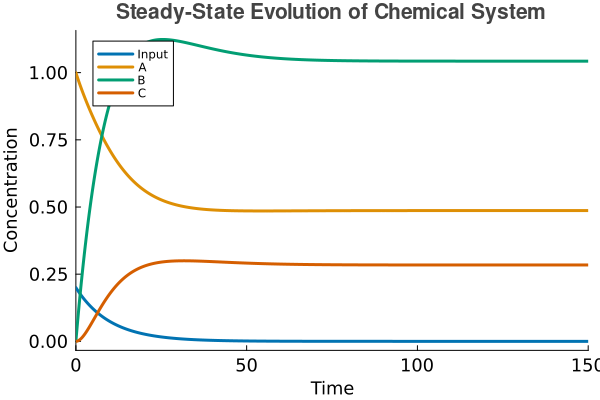

In [43]:
function chemsys!(du, u, p, t)
    X, A, B, C = u
    p1, p2, k1, k2, c1, c2 = p
    du[1] = -p1.*X
    du[2] = p1.*X+((p2)./(1 .+C)) .- (k1+c1).*A
    du[3] = k1.*A .- k2.*B
    du[4] = (k2.*B)./(1 .+C) .- c2.*C
end;

# parameter names and the compartment names 
pars_names = ["p1", "p2", "k1", "k2", "c1", "c2"]
output_names = ["X", "A", "B", "C"]

# parameters
u0 = [0.2, 1., 0., 0.]
parameters = [0.1, 0.1, 0.15, 0.07, 0.01, 0.2]
tspan = (0., 150.)

# and create an ode problem to solve
problem = ODEProblem(chemsys!, u0, tspan, parameters);

# the solution can be obtained easily
solution = DifferentialEquations.solve(problem);

plot(solution, linewidth=3, labels=["Input" "A" "B" "C"], xlabel="Time", ylabel="Concentration", 
title="Steady-State Evolution of Chemical System", titlefontfamily = "Helvetica Bold", 
labelfontsize = 12, titlefontsize = 14, tickfontsize = 12, palette=:seaborn_colorblind, grid=false)


## Local Parameter Sensitivity Analysis

Local parameter sensitivity analysis analyzes the model based on a local parameter values in parameter vector $p$. Therefore, we will need a cost functional, which can for example be the area under the curve of the model equations, defined as

\begin{equation}
S_c = \int_0^T f_c(t)dt 
\end{equation}

for model compartment $c$. We can observe how this quantity changes based on local changes in parameter values. Given a uniform grid of steps $t_s$, we can define the discretized auc as

\begin{equation}
S_c \approx t_s \left(\sum_{k=1}^{N-1} f(t_k; p) + \frac{f(t_N;p) + f(t_0;p)}{2}\right)
\end{equation} 

In [80]:
function aucsens(p, comp, tstep=1e-3)
    sol = Array(solve(problem, p=p, abstol=1e-14, reltol=1e-14, saveat=tstep, sensealg=ForwardDiffSensitivity()))
    tstep * (sum(sol[comp, 2:end-1]) + 1/2*(sol[comp, 1]+sol[comp, end]))
end

aucsens (generic function with 2 methods)

### LPSA with finite differences (Classic style)

We can define the sensitivity index of a parameter as
\begin{equation}
I_{p,c} = Mean(\frac{|S_{c,p+}-S_{c,0}|}{f}; \frac{|S_{c,p-}-S_{c,0}|}{f})
\end{equation}

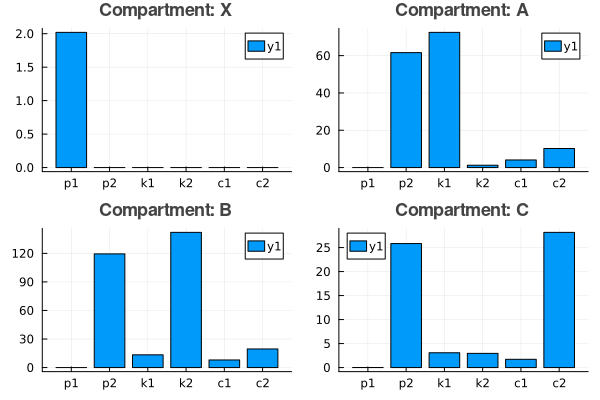

In [98]:
# for each component and parameter
sensitivities = fill(0., length(parameters), 4)
perturbation_index = 0.1

for ip in eachindex(parameters)
    p_tmp_low = copy(parameters)
    p_tmp_high = copy(parameters)
    p_tmp_low[ip] *= (1-perturbation_index)
    p_tmp_high[ip] *= (1+perturbation_index)
    for cmp in 1:4
        auc_0 = aucsens(parameters, cmp)
        sensitivities[ip,cmp] = 0.5 * (abs(aucsens(p_tmp_low, cmp)-auc_0)/perturbation_index + abs(aucsens(p_tmp_high, cmp)-auc_0)/perturbation_index)
    end
end

plot([bar(pars_names, sensitivities[:,idx], title="Compartment: $(output_names[idx])", titlefontfamily="Helvetica Bold", titlefontsize=12) for idx in eachindex(output_names)]..., layout=4)


### LPSA with autodiff (Gangnam style)

Another possibility is to utilize automatic differentiation, such as Zygote, to compute the sensitivities as
\begin{equation}
I_c = \left| \frac{\mathrm{d}S_c}{\mathrm{d}p}\right|
\end{equation}

In [85]:
autodiff_sensitivities = fill(0., length(parameters), 4)
for i in 1:4
autodiff_sensitivities[:,i] = abs.(Zygote.gradient((p) -> aucsens(p, i), parameters)[1])
end

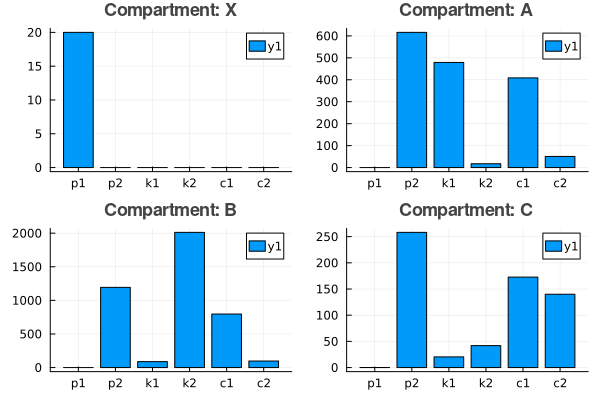

In [86]:
plot([bar(pars_names, autodiff_sensitivities[:,idx], title="Compartment: $(output_names[idx])", titlefontfamily="Helvetica Bold", titlefontsize=12) for idx in eachindex(output_names)]..., layout=4)


### LPSA with autodiff 2 (Extreme Gangnam Style)
Observe that given the derivative of our $f(p)$ to the parameters as $f'_i(p)$, we can write $\frac{\mathrm{d}S_c}{\mathrm{d}p}$ as:
\begin{equation}
\frac{\mathrm{d}S_c}{\mathrm{d}p} = t_s \left(\sum_{k=1}^{N-1} f'(t_k; p) + \frac{f'(t_N;p) + f'(t_0;p)}{2}\right)
\end{equation}

## MPSA applied to the Chemical Reaction System

As an example, the MPSA will be applied to the above Chemical Reaction System to determine the importance of the different model parameters in relation to the model outputs (`X`, `A`, `B` and `C`. Note: `X` is actually the input rather than 'output'). 

In [3]:
# Make a function that will return the solution of a specific model output (cnr = compartment number)

function chem_model_sims!(pars, tspan, cnr)
    
    problem = ODEProblem(chemsys!, u0, tspan, pars)
    solution = DifferentialEquations.solve(problem)

    output_sol = solution(tspan[1]:tspan[end], idxs=cnr).u

    return output_sol 
end 


chem_model_sims! (generic function with 1 method)

Below is we run the MPSA algorithm for the above system/model. 

In [4]:
Y_score = Any[] # An array to store the KS scores 

for cnr in 1:length(output_names)
    # Initialize the MPSA before testing for significance

    # First select the estimated parameters which are labelled as par0 and
    # generate the output using par0 which is feature0. Features are the model outputs 
    par0 = parameters  
    feature0 = chem_model_sims!(par0, tspan, cnr)  

    # Initialize Latin Hypercube Sampling using a X number of Monte Carlo
    # simulations
    Np = length(par0)       # no. of parameters (rate constants, initial conditions) included in analysis
    Nd = 50                 # no. of dummies
    n_MPSA = 10000          # no. of parameter ensembles / no. of Monte Carlo simulations

    # Latin Hypercube Sampling (LHS) of parameter space
    scale = scaleLHC(randomLHC(n_MPSA, Np+Nd), fill((0., 1.), Np+Nd))  # random uniform distributed parameter sets (values [0,1])
                                      # (scale is an n_MPSA x Np+Nd matrix)

    # Adjust parameter sets for par_MC to reference values par0:
    # e.g. 0.1*par0[i] < par_MC[i,j] < 10*par0[i]

    # Adjust the parameter sets for the MSPA and defined as par_MC
    par_MC_sub = zeros(n_MPSA, length(par0))
    for n = 1:n_MPSA
        for m = 1:length(par0)
            par_val = scale[n, m]

            if (par_val > 0.1*par0[m]) && (par_val < 10*par0[m])
                par_MC_sub[n, m] = par_val
            else
                par_MC_sub[n, m] = par0[m] + 0.1*rand()
            end
        end
    end

    # Sample the parameters generated using the LHS design and
    # monte carlo simulations
    par_MC = [par_MC_sub scale[:, length(par0) + 1:Np+Nd]] # The parameters from the monte carlo simulations


    # Monte Carlo simulations (X iterations)

    # Monte Carlo simulations
    # Loop through the number of monte carlo simulations
    V = zeros(n_MPSA)
    @inbounds for j = 1:n_MPSA
        partemp = par_MC[j, 1:Np] #select the Np model parameters from set j

        # Simulate model for partemp and calculate feature of interest from
        # from selected model outputs
        feature = chem_model_sims!(partemp, tspan, cnr)

        # Calculate sensitivity criterion
        # Sum of squared differences between the perturbed and reference output as example
        SSE = sum((feature0 .- feature).^2)
        V[j] = SSE
    end 

    # Classification of acceptable vs unacceptable simulations
    flag = zeros(n_MPSA)
    Sa = zeros(n_MPSA, Np+Nd)
    Su = zeros(n_MPSA, Np+Nd)
    value = zeros(n_MPSA, Np+Nd)

    threshold = mean(V) # mean as threshold
    acc = findall(V .<= threshold)
    unacc = findall(V .> threshold)
    flag[acc] .= 1

    # Cumulative distributions (for model parameters and dummies)
    @inbounds for i = 1:Np+Nd
        temp = [par_MC[:, i] flag]  # associate 1 to acceptable cases and 0 to unacceptable parameter values
        temp = temp[sortperm(temp[:, 1]), :]  # sorts temp based on column 1

        value[:, i] = temp[:, 1]
        Sa[:, i] = cumsum(temp[:, end])
        Su[:, i] = cumsum(-1*temp[:, end] .+ ones(n_MPSA))  
        Sa[:, i] = Sa[:, i] / maximum(Sa[:, i])
        Su[:, i] = Su[:, i] / maximum(Su[:, i])
    end 

    K_S = maximum(abs.(Sa-Su), dims=1)
    
    Y = K_S[:, 1:Np]

    push!(Y_score, Y)

end




Generate the plots (sensitivity analysis) for all 4 model outputs (`X`, `A`, `B` and `C`).

In [5]:
# Make an array to store all the plots, so it can be used later on for plotting convenience. 
mpsa_plots = Any[] 

# Loop through all the model outputs and the model parameters KS score
for k = 1:length(output_names)

    plotMPSA = bar(pars_names, Y_score[k]',  bar_width=[0.5, 0.5, 0.5, 0.5], 
    xlabel = (k == 3 || k == 4) ? "Parameters" : "", ylabel = (k == 1 || k == 3) ? "KS score" : "", 
    labels="KS Score", title="Compartment: $(output_names[k])",ylim=(0., 1.), 
    itlefontfamily = "Helvetica Bold", labelfontsize = 12, titlefontsize = 14, 
    tickfontsize = 12, palette=:seaborn_colorblind, grid=false)

    plotMPSA= hline(plotMPSA, [0.05], linestyle=:dash, linewidth=3, color=:darkred, labels="KS threshold")

    # Save the plot in the mpsa_plots array 
    push!(mpsa_plots, plotMPSA)

end 


Below we have all the four MPSA plots. A model parameter with KS score above the threshold (red dashed line at 0.05) means that it is sensitive and has a significant impact on the corresponding model output. 

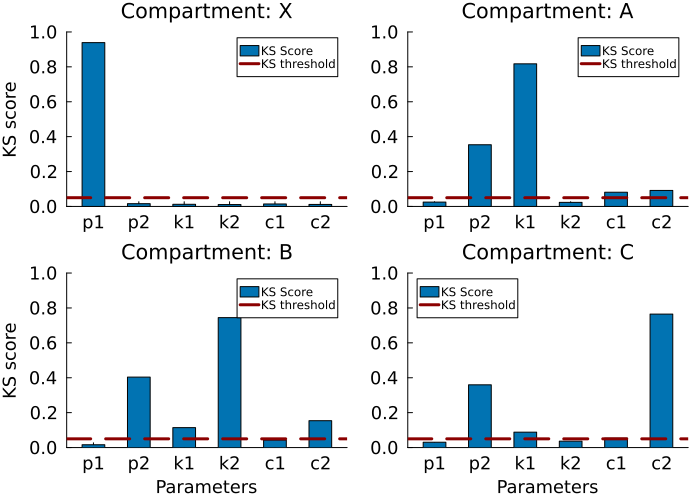

In [6]:
# Generate all the MPSA plots 
plot(mpsa_plots..., layout=(2,2), size=(700,500))

You can also display the MPSA plot for one model output, for example: `Compartment B`. We see that only parameters $p2$, $k1$, $k2$ and $c2$ are sensitive with respect to compartment B. However, one might argue that parameter $c1$ is also sensitive (it lies on the threshold line).

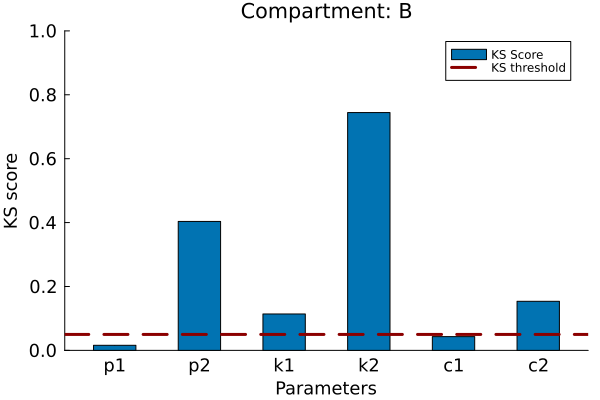

In [7]:
# Just select the correct index that corresponds to compartment B from the mpsa_plots array
mpsa_plots[3]